# Import Libraries

In [170]:
import requests
import json
import spotipy
import string
import mysql.connector
import os
import itertools
import pandas as pd
import numpy as np 
import seaborn as sns
plt.style.use('seaborn')
import pickle
import scipy as sp
import xgboost as xgb
import scipy.stats as stats
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from tqdm import tqdm
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyClientCredentials
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder


## Data Cleaning and EDA

Uploaded data from spotify data notebook

In [535]:
df_weekly = pd.read_csv('spotify_weekly.csv', sep = ';')
df_artists = pd.read_csv('artists.csv', sep = ';')
df_features = pd.read_csv('audio_features.csv', sep = ';')
df_albums = pd.read_csv('album_features.csv', sep = ';')
df_unique = pd.read_csv('weekly_features_pd.csv')

Rename columns to match with features df for successful merge


In [536]:
df_artists.rename(columns = {'name': 'artist'}, inplace = True)

Merge dataframes to match track features with track placement on charts


In [537]:
weekly_features = pd.merge(df_weekly, df_features, how = 'left', on = 'id')

In [538]:
weekly_features.sort_values('num_of_streams', ascending = False)

,id,week_of,chart_position,track_name,artist,num_of_streams,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,time_signature
10996,14msK75pk3pA33pzPVNtBF,55,1,7 rings,Ariana Grande,71467874,0.725,0.321,-10.744,0.323,0.578,0.000,0.088,0.319,70.142,178640,4.0
3600,0bAkKNCQfWkexHFn7fIKns,18,1,In My Feelings,Drake,67499798,0.735,0.482,-9.445,0.139,0.006,0.014,0.448,0.315,181.995,217933,4.0
8200,0TK2YIli7K1leLovkQiNik,41,1,Señorita,Shawn Mendes,67237638,0.759,0.540,-6.039,0.029,0.037,0.000,0.095,0.750,116.947,190960,4.0
18596,0TK2YIli7K1leLovkQiNik,93,1,Señorita,Shawn Mendes,66933317,0.759,0.540,-6.039,0.029,0.037,0.000,0.095,0.750,116.947,190960,4.0
9196,2G7V7zsVDxg1yRsu7Ew9RJ,46,1,In My Feelings,Drake,65825491,0.835,0.626,-5.833,0.125,0.059,0.000,0.396,0.350,91.030,217925,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,19a3JfW8BQwqHWUMbcqSx8,25,196,Famous,Kanye West,2580512,0.465,0.735,-3.715,0.117,0.071,0.000,0.098,0.409,173.935,196040,4.0
5196,2q6tgiA9tpb6DMguABwCWE,25,197,All of Me,John Legend,2568720,0.422,0.264,-7.064,0.032,0.922,0.000,0.132,0.331,119.930,269560,4.0
5197,494OU6M7NOf4ICYb4zWCf5,25,198,Sugar,Maroon 5,2541963,0.748,0.788,-7.055,0.033,0.059,0.000,0.086,0.884,120.076,235493,4.0
5198,2jyjhRf6DVbMPU5zxagN2h,25,199,Let Her Go,Passenger,2536282,0.509,0.538,-7.335,0.057,0.385,0.000,0.104,0.244,75.089,252867,4.0


Merging weekly features and artists into the master dataframe

In [539]:
df_master = pd.merge(weekly_features, df_artists, how = 'left', on = 'artist')

In [540]:
df_master.sort_values('popularity_score', ascending = False)

,id_x,week_of,chart_position,track_name,artist,num_of_streams,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,time_signature,id_y,popularity_score,num_of_followers
20440,2C6WXnmZ66tHhHlnvwePiK,102,45,Die For Me (feat. Future & Halsey),Post Malone,10373799,0.614,0.660,-2.848,0.044,0.190,0.000,0.211,0.452,145.010,245267,4.0,246dkjvS1zLTtiykXe5h60,100.0,20854501.0
17596,7wGoVu4Dady5GV0Sv4UIsx,88,1,rockstar,Post Malone,29659184,0.577,0.522,-6.594,0.098,0.130,0.000,0.142,0.119,159.772,218320,4.0,246dkjvS1zLTtiykXe5h60,100.0,20854501.0
2485,5yuShbu70mtHXY0yLzCQLQ,12,86,Go Flex,Post Malone,5934885,0.665,0.498,-8.185,0.083,0.228,0.000,0.076,0.127,81.967,179613,4.0,246dkjvS1zLTtiykXe5h60,100.0,20854501.0
21433,7dt6x5M1jzdTEt8oCbisTK,107,38,Better Now,Post Malone,11775588,0.680,0.578,-5.804,0.040,0.331,0.000,0.135,0.341,145.038,231267,4.0,246dkjvS1zLTtiykXe5h60,100.0,20854501.0
10002,6MWtB6iiXyIwun0YzU6DFP,50,7,Wow.,Post Malone,22700765,0.833,0.539,-7.399,0.178,0.163,0.000,0.101,0.385,99.947,149520,4.0,246dkjvS1zLTtiykXe5h60,100.0,20854501.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29918,1839RWzPRZCVgvamu4sHSN,149,124,All My Love (feat. Conor Maynard),Cash Cash,4273200,0.590,0.871,-3.353,0.089,0.148,0.000,0.074,0.304,134.956,191331,4.0,NaN,NaN,NaN
30391,48yAM9xWBwT4Ac9G1y20rw,151,197,Explícale,Yandel,3100361,0.808,0.690,-4.151,0.148,0.058,0.000,0.103,0.640,125.086,223147,4.0,NaN,NaN,NaN
30759,01vR5Z7AHinp9D2wu2BNQS,153,165,UP IN SMOKE,RIN,5126611,0.791,0.663,-5.655,0.153,0.235,0.000,0.117,0.314,77.494,174600,4.0,NaN,NaN,NaN
30949,1SSzM044DUbVpYNNHWIhYJ,154,155,Vermissen (feat. Henning May),Juju,5164410,0.718,0.667,-5.008,0.055,0.169,0.000,0.067,0.480,89.029,161882,4.0,NaN,NaN,NaN


Dropping NaN's from popularity score

In [541]:
pop_score = df_master['popularity_score'].dropna()

In [542]:
acousticness = df_master['acousticness']

In [543]:
df_unique.sort_values('acousticness', ascending = False)

,Unnamed: 0,id,week_of,chart_position,track_name,artist,num_of_streams,num_times,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,time_signature
1823,1823,4tHqQMWSqmL6YjXwsqthDI,16,123,Carol of the Bells,Mykola Dmytrovych Leontovych,7362398,6,0.418,0.106,-22.507,0.045,0.994,0.029,0.179,0.800,46.718,85267,4.0
322,322,0Uv5Kp8sEnriJjkX4oLfNI,8,127,Paul - Skit,Paul Rosenberg,5139520,2,0.636,0.335,-13.327,0.966,0.993,0.000,0.342,0.561,161.680,35240,4.0
1351,1351,3ITvHA9zhZZdBJsOsAUegF,2,116,Amorfoda,Bad Bunny,5573531,17,0.742,0.432,-7.539,0.062,0.984,0.000,0.080,0.252,148.005,155676,3.0
415,415,14JzyD6FlBD5z0wV5P07YI,5,51,when the party's over,Billie Eilish,9681823,23,0.498,0.104,-14.080,0.062,0.979,0.000,0.090,0.205,124.001,199931,3.0
842,842,299lFlaAsNQdgbIZNPmIA0,88,127,Christmas Time Is Here - Vocal,Vince Guaraldi Trio,5457722,1,0.388,0.145,-19.697,0.032,0.978,0.000,0.100,0.091,75.474,166387,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,1257,3agtg0x11wPvLIWkYR39nZ,105,138,Somewhere I Belong,Linkin Park,4067269,1,0.451,0.951,-3.754,0.065,0.000,0.000,0.261,0.442,162.065,213933,4.0
1832,1832,4U9arGcc4ATa7shChhLQP0,135,199,Walk On Water,Thirty Seconds To Mars,3278983,1,0.494,0.778,-7.041,0.036,0.000,0.000,0.090,0.406,139.963,188228,4.0
1148,1148,2wOXxtHZgRkkrkEbKLzzqs,44,161,1.5,21 Savage,5894178,1,0.885,0.520,-8.353,0.359,0.000,0.000,0.454,0.306,84.022,148656,4.0
1063,1063,2QpGZOhTCHHiKmpSO9FW4h,57,11,Follow God,Kanye West,17466061,6,0.529,0.900,-3.503,0.418,0.000,0.000,0.043,0.434,180.291,104591,4.0


In [544]:
df_unique.drop('Unnamed: 0', axis =1, inplace=True)


In [545]:
df_master.isnull().sum().sum()

264

In [546]:
df_master.dropna(inplace=True)

## Visualizations

Checking the popularity of songs based on the weighted features of each song

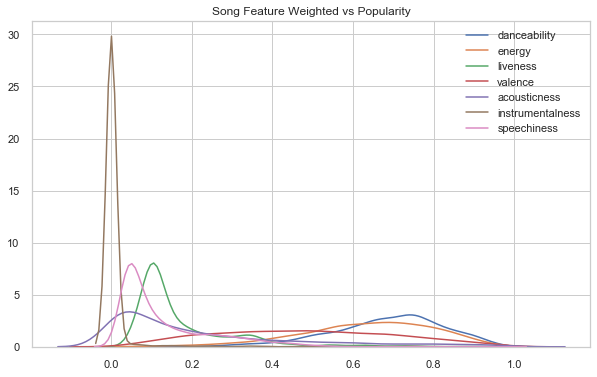

In [547]:
fig, ax = plt.subplots(figsize=[10,6])
sns.kdeplot(df_unique['danceability'])
sns.kdeplot(df_unique['energy'])
sns.kdeplot(df_unique['liveness'])
sns.kdeplot(df_unique['valence'])
sns.kdeplot(df_unique['acousticness'])
sns.kdeplot(df_unique['instrumentalness'])
sns.kdeplot(df_unique['speechiness'])
plt.title('Song Feature Weighted vs Popularity')
plt.show()

# because x is 0 and there is not much instrumentalness, there were a lot of top 200 songs with no instru
# Y axis is in the thousands and x axis is the feature number

Creating the Top 10 for song positions on the music charts

In [548]:
top_ten = df_unique[df_unique['chart_position']<=10]

In [549]:
top_ten.sort_values('num_times', ascending = False)

,id,week_of,chart_position,track_name,artist,num_of_streams,num_times,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,time_signature
2954,7qiZfU4dY1lWllzX7mPBI3,0,1,Shape of You,Ed Sheeran,64275251,153,0.825,0.652,-3.183,0.080,0.581,0.000,0.093,0.931,95.977,233713,4.0
297,0tgVpDi06FyKpA1z0VMD4v,0,7,Perfect,Ed Sheeran,24795623,144,0.599,0.448,-6.312,0.023,0.163,0.000,0.106,0.168,95.050,263400,3.0
2580,6RUKPb4LETWmmr3iAEQktW,0,5,Something Just Like This,The Chainsmokers,30048981,125,0.617,0.635,-6.769,0.032,0.050,0.000,0.164,0.446,103.019,247160,4.0
1089,2RttW7RAu5nOAfq6YFvApB,0,10,Happier,Ed Sheeran,23574465,89,0.522,0.385,-7.355,0.029,0.536,0.000,0.135,0.236,89.792,207520,4.0
2810,7dt6x5M1jzdTEt8oCbisTK,2,2,Better Now,Post Malone,32111555,87,0.680,0.578,-5.804,0.040,0.331,0.000,0.135,0.341,145.038,231267,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2714,72Q0FQQo32KJloivv5xge2,78,2,I'm the One,DJ Khaled,33067187,1,0.599,0.667,-4.267,0.037,0.053,0.000,0.134,0.817,80.984,288877,4.0
1850,4VginDwYTP2eaHJzO0QMjG,153,2,Circles,Post Malone,32068232,1,0.704,0.758,-3.537,0.040,0.233,0.001,0.092,0.534,120.003,214907,4.0
2618,6UFEJuDXQMWhL5UH5f9fUR,98,7,Enemies (feat. DaBaby),Post Malone,25861671,1,0.542,0.674,-4.169,0.210,0.059,0.000,0.096,0.667,76.388,196760,4.0
1886,4Yq3XUNfWrAPWuB94qkC09,98,6,Take What You Want (feat. Ozzy Osbourne & Trav...,Post Malone,27875018,1,0.499,0.800,-2.665,0.050,0.091,0.000,0.147,0.272,139.919,229573,4.0


Visualizing the Top 200 songs compared to the Top 10 songs in regards to the feature Danceability

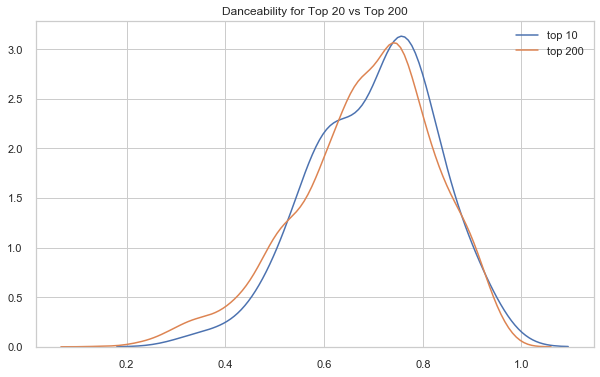

In [550]:
fig, ax = plt.subplots(figsize=[10,6])
sns.kdeplot(top_ten['danceability'], label = 'top 10')
sns.kdeplot(df_unique['danceability'], label = 'top 200')
plt.title('Danceability for Top 20 vs Top 200')
plt.show()

# Most songs had .8 danceability

Visualizing the Top 200 songs compared to the Top 10 songs in regards to the feature Loudness

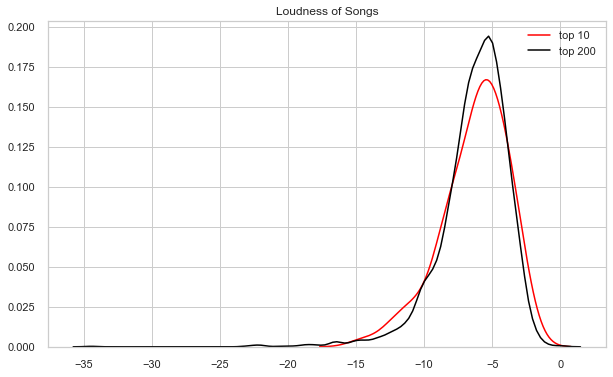

In [551]:
fig, ax = plt.subplots(figsize=[10,6])
sns.kdeplot(top_ten['loudness'], label = 'top 10', color = 'red')
sns.kdeplot(df_unique['loudness'], label = 'top 200', color = 'black')
plt.title('Loudness of Songs')
plt.show()

Visualizing the Top 200 songs compared to the Top 10 songs in regards to the feature Liveness

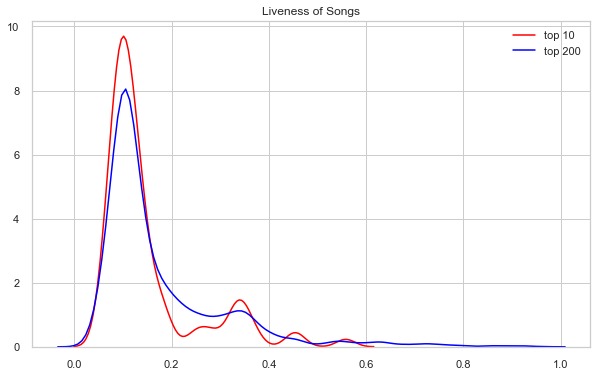

In [552]:
fig, ax = plt.subplots(figsize=[10,6])
sns.kdeplot(top_ten['liveness'], label = 'top 10', color = 'red')
sns.kdeplot(df_unique['liveness'], label = 'top 200', color = 'blue')
plt.title('Liveness of Songs')
plt.show()

In [553]:
top_ten['liveness'].std(), df_unique['liveness'].std()


(0.10110372509350708, 0.13269716532580722)

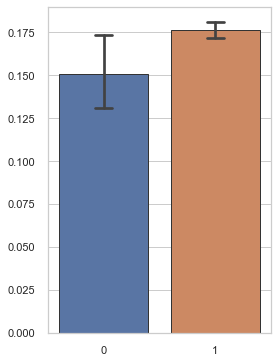

In [554]:
df_bar = [top_ten['liveness'], df_unique['liveness']]

fig, ax = plt.subplots(1,1,figsize=[4,6])
sns.barplot(data=df_bar, ax=ax,capsize=.15, lw=1, edgecolor=".2", ci=95) # SEM errorbars
plt.show()

Visualizing the Acousticness of a song compared to the time on the charts

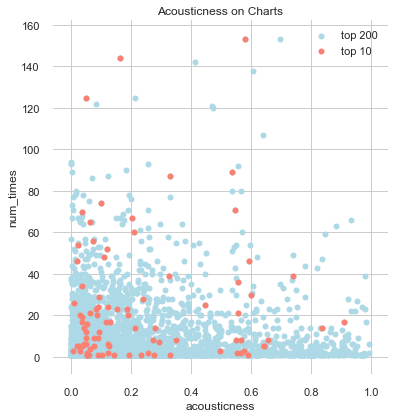

In [555]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 6.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(x= df_unique['acousticness'], y = df_unique['num_times'],
                sizes=(1, 8), linewidth=0,
                 ax=ax, color = 'lightblue', label = 'top 200')
                    
sns.scatterplot(x= top_ten['acousticness'], y = top_ten['num_times'],
                sizes=(1, 8), linewidth=0,
                 ax=ax, color = 'salmon', label = 'top 10')                    
plt.title('Acousticness on Charts')
plt.show()

Visualizing the Danceability of a song compared to the time on the charts

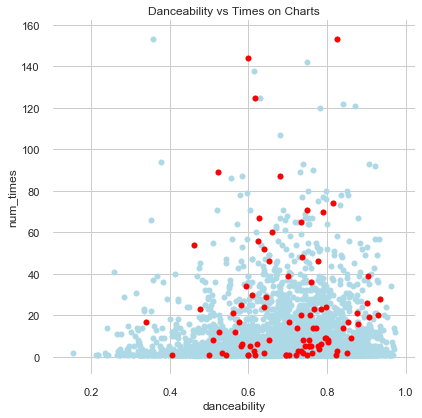

In [556]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(x= df_unique['danceability'], y = df_unique['num_times'],
                sizes=(1, 8), linewidth=0,
                 ax=ax, color = 'lightblue')
                    
sns.scatterplot(x= top_ten['danceability'], y = top_ten['num_times'],
                sizes=(1, 8), linewidth=0,
                 ax=ax, color = 'red')                    
plt.title('Danceability vs Times on Charts')
plt.show()

Visualizing the Tempo of a song compared to the time on the charts

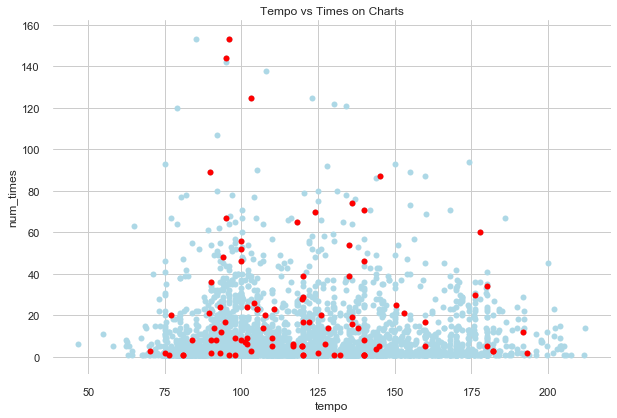

In [557]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 6.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(x= df_unique['tempo'], y = df_unique['num_times'],
                sizes=(1, 8), linewidth=0,
                 ax=ax, color = 'lightblue')
                    
sns.scatterplot(x= top_ten['tempo'], y = top_ten['num_times'],
                sizes=(1, 8), linewidth=0,
                 ax=ax, color = 'red')                    
plt.title('Tempo vs Times on Charts')
plt.show()

In [558]:
top_live_mean = top_ten['liveness'].mean()
top_live_mean

0.15037078651685398

## Hypothesis Testing

### T Test

Top 10 vs Top 200

- Ho: There is no difference in acousticness in the Top 10 songs of the Top 200 list

- Ha: There is a difference in acousticness in the Top 10 songs of the Top 200 list

We fail to reject the Null hypothesis. There is no significant significance 

In [559]:
stats.ttest_1samp(top_ten['acousticness'], df_unique['acousticness'].mean())


Ttest_1sampResult(statistic=0.482601584482359, pvalue=0.6305769979326019)

# Baseline Model

Creating a baseline model. Going to use F1 score as the chosen metric

In [560]:
df_master['Top_10']= np.where(df_master['chart_position']<=10,1,0)

In [561]:
y.value_counts(normalize=True)

0    0.949914
1    0.050086
Name: Top_10, dtype: float64

## Preprocessing

Preprocessed data between continuous and categorical variables 

In [562]:
X = df_master.drop(columns=['Top_10'])
y = df_master['Top_10']

continuous_columns = ['week_of','chart_position','num_of_streams','danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration','time_signature','popularity_score','num_of_followers']
categorical_columns = [x for x in X.columns if x not in continuous_columns]


In [563]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

#### One Hot Encoder (Categorical Features)


In [564]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
_X_train_ohe = ohe.fit_transform(X_train[categorical_columns]).toarray()
_X_train_ohe_df = pd.DataFrame(data = _X_train_ohe,
                        columns = ohe.get_feature_names(categorical_columns))

_X_test_ohe = ohe.transform(X_test[categorical_columns]).toarray()
_X_test_ohe_df = pd.DataFrame(data = _X_test_ohe,
                        columns = ohe.get_feature_names(categorical_columns))

#### Standard Scaler (Continuous Features)


In [565]:
scaler = StandardScaler()
_X_train_cont = scaler.fit_transform(X_train[continuous_columns])
_X_train_cont_df = pd.DataFrame(data = _X_train_cont,
                         columns = continuous_columns)

_X_test_cont = scaler.transform(X_test[continuous_columns])
_X_test_cont_df = pd.DataFrame(data = _X_test_cont,
                         columns = continuous_columns)

#### Merge Continuous Features with Categorical Features


In [566]:
_X_test_merged = _X_test_cont_df[continuous_columns].merge(_X_test_ohe_df, left_index=True, right_index=True)
_X_train_merged = _X_train_cont_df[continuous_columns].merge(_X_train_ohe_df, left_index=True, right_index=True)
_X_train_merged.shape

(24725, 6453)

#### Oversampling with SMOTE


In [567]:
_smote = SMOTE(sampling_strategy='minority', random_state=42)
_X_train_merged, y_train = _smote.fit_sample(_X_train_merged, y_train)

### Dummy Classifier

The dummy classifier is our baseline model. We will use this to compare future models throughout this notebook

In [568]:
from sklearn.metrics import precision_score, f1_score, plot_confusion_matrix, accuracy_score, recall_score

In [569]:
# Recall = TP / (TP + FN)
# Precision = TP / (TP + FP)
# F1 = (2*Precision*Recall) / Precision + Recall
#Classifying everything as not top 10 so it gives an F1 score of 0

In [570]:
dummy_clf = DummyClassifier(strategy='constant', constant=0)
dummy_clf.fit(_X_train_merged, y_train)
dummy_train_pred = dummy_clf.predict(_X_train_merged)
dummy_pred = dummy_clf.predict(_X_test_merged)

print('Training Accuracy: ', accuracy_score(y_train, dummy_train_pred))
print('Testing Accuracy: ',accuracy_score(y_test, dummy_pred))
print('\n\n')
print('Training F1-Score: ', f1_score(y_train, dummy_train_pred))
print('Testing F1-Score: ', f1_score(y_test, dummy_pred))
print('\n\n')
print('Training Recall: ', recall_score(y_train, dummy_train_pred))
print('Testing Recall: ',recall_score(y_test, dummy_pred))


Training Accuracy:  0.5
Testing Accuracy:  0.9498544160465868



Training F1-Score:  0.0
Testing F1-Score:  0.0



Training Recall:  0.0
Testing Recall:  0.0


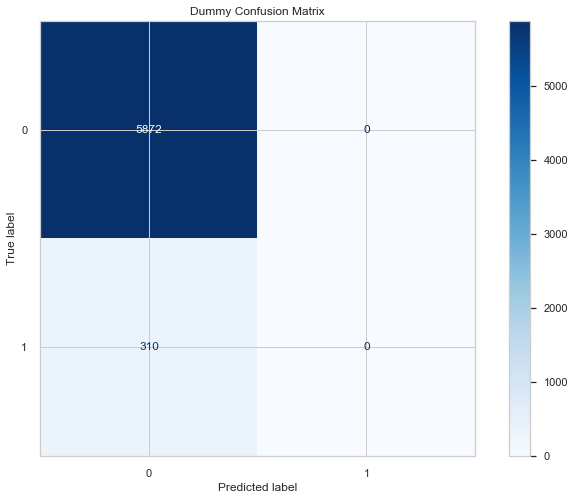

In [571]:
# plot confusion matrix
fig,ax = plt.subplots(figsize=(12,8))
plot_confusion_matrix(dummy_clf, _X_test_merged, y_test, cmap = 'Blues', values_format='d' , ax= ax)
ax.set_title('Dummy Confusion Matrix')
fig.savefig('Dummy_Confusion_Matrix');

The dummy classifier classified everything as "Not Top 10" due to significant class imbalance

# Additional Models

Creating a dataframe without unnecessary columns

In [572]:
columns_to_drop= ['id_x', 'week_of', 'chart_position', 'track_name','num_of_streams','time_signature', 'id_y', 'popularity_score','num_of_followers', 'artist']
df_modeling= df_master.drop(columns= columns_to_drop)


In [573]:
df_modeling= pd.get_dummies(df_modeling)

In [574]:
df_modeling.corr()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,Top_10
danceability,1.000000,0.036525,0.114612,0.182618,-0.196097,-0.010130,-0.046267,0.323928,-0.103813,-0.098897,0.024438
energy,0.036525,1.000000,0.751240,-0.047149,-0.480262,-0.069138,0.064755,0.376809,0.081263,0.025982,-0.024726
loudness,0.114612,0.751240,1.000000,-0.150256,-0.381628,-0.142434,0.005643,0.340068,0.032559,0.018092,0.012990
speechiness,0.182618,-0.047149,-0.150256,1.000000,-0.061556,-0.012574,0.028252,-0.006881,0.179684,-0.047067,-0.013873
acousticness,-0.196097,-0.480262,-0.381628,-0.061556,1.000000,0.070571,-0.072001,-0.045069,-0.106970,-0.028227,-0.004819
instrumentalness,-0.010130,-0.069138,-0.142434,-0.012574,0.070571,1.000000,0.002846,-0.081191,0.029870,-0.007557,-0.000567
liveness,-0.046267,0.064755,0.005643,0.028252,-0.072001,0.002846,1.000000,0.000046,-0.005262,-0.012741,-0.029654
valence,0.323928,0.376809,0.340068,-0.006881,-0.045069,-0.081191,0.000046,1.000000,-0.048825,-0.087891,0.011573
tempo,-0.103813,0.081263,0.032559,0.179684,-0.106970,0.029870,-0.005262,-0.048825,1.000000,0.013175,-0.024493
duration,-0.098897,0.025982,0.018092,-0.047067,-0.028227,-0.007557,-0.012741,-0.087891,0.013175,1.000000,-0.006285


### Logistic Regression

In [576]:
target = df_modeling['Top_10']
df_features = df_modeling.drop(['Top_10'], axis=1)

In [459]:
#df_features = df_master.drop(columns = ['Top_10', 'num_of_streams', 'popularity_score', 'num_of_followers', 'week_of',
#                                       'track_name', 'id_x', 'time_signature', 'id_y', 'chart_position'])

In [577]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25,test_size=0.30)

In [578]:
log = LogisticRegression()
log.fit(X_train, y_train)
log_preds = log.predict(X_test)

log_f1 = metrics.f1_score(y_test, log_preds)
log_acc = metrics.accuracy_score(y_test, log_preds)

print(classification_report(y_test, log_preds, target_names=['Top 200','Top 10']))

              precision    recall  f1-score   support

     Top 200       0.95      1.00      0.97      8816
      Top 10       0.00      0.00      0.00       457

    accuracy                           0.95      9273
   macro avg       0.48      0.50      0.49      9273
weighted avg       0.90      0.95      0.93      9273



/Users/joeybillet/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see from our F1 score that our model nearly exclusively picked the Top 200 class. This indicates that our model could be skewed towards a class imbalance


### Class Imbalance

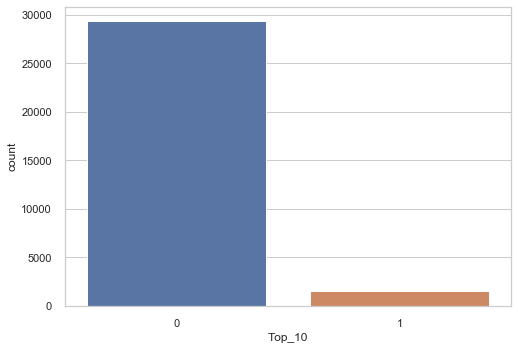

In [579]:
sns.countplot(x="Top_10", data= df_modeling);

The chart above confirms our suspicision of a class imbalance, we can see that our data is severely skewed towards our Top 200 class.

To solve our class imbalance we are going to create synthetic cases in our Top 10 class using SMOTE.

In [580]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
#X_train, y_train= X_train_resampled, y_train_resampled
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

-----------------------------------------
Synthetic sample class distribution: 

1    20543
0    20543
Name: Top_10, dtype: int64


In [581]:
log = LogisticRegression()
log.fit(X_train_resampled, y_train_resampled)
log_preds = log.predict(X_test)

log_f1 = metrics.f1_score(y_test, log_preds)
log_acc = metrics.accuracy_score(y_test, log_preds)
print('F1: ',log_f1)
print('Acc: ',log_acc)
print(classification_report(y_test, log_preds, target_names=['Top 200','Top 10']))

F1:  0.09849119865884326
Acc:  0.5360724684568101
              precision    recall  f1-score   support

     Top 200       0.96      0.54      0.69      8816
      Top 10       0.05      0.51      0.10       457

    accuracy                           0.54      9273
   macro avg       0.50      0.53      0.39      9273
weighted avg       0.91      0.54      0.66      9273



In [582]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[4736 4080]
 [ 222  235]]


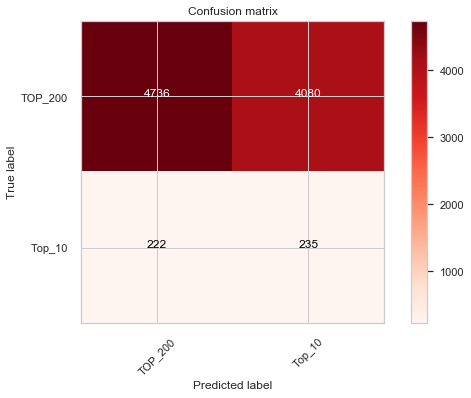

In [583]:
cm = confusion_matrix(y_test,log_preds)
classes = ['TOP_200','Top_10']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

While we previously solved for the class imbalance we see that it didn't help with our logistic regression model. This tells me that the logistic regression model is likely not the best model for my problem

### Logistic with Class weight balanced

In [617]:
lr_clf_weighted = LogisticRegression(solver='liblinear', class_weight = 'balanced')
lr_clf_weighted.fit(X_train, y_train)
y_weighted_train = lr_clf_weighted.predict(X_train)
y_weighted_test = lr_clf_weighted.predict(X_test)

f1_train = metrics.f1_score(y_train, y_weighted_train)
f1_test = metrics.f1_score(y_test, y_weighted_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_weighted_test))
print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Test Accuracy score:  0.5440526259031597
Train F1 score:  0.10920212287487631
Test F1 score:  0.10195412064570943


In [618]:
coef_names = list(zip(df_features.columns, lr_clf_weighted.coef_[0]))

In [619]:
coef_names

[('danceability', 0.8054426012150899),
 ('energy', -2.1744090083184),
 ('loudness', 0.09281725435537852),
 ('speechiness', -0.42519188522654866),
 ('acousticness', -0.4020229402251261),
 ('instrumentalness', -0.23811211604684837),
 ('liveness', -1.4786553959882331),
 ('valence', 0.19005913537532595),
 ('tempo', -0.002497176313964908),
 ('duration', 4.061267547654066e-07)]

In [620]:
log_bal = sorted(coef_names, key=lambda x: abs(x[1]), reverse = True)


In [621]:
log_bal[0:15]

[('energy', -2.1744090083184),
 ('liveness', -1.4786553959882331),
 ('danceability', 0.8054426012150899),
 ('speechiness', -0.42519188522654866),
 ('acousticness', -0.4020229402251261),
 ('instrumentalness', -0.23811211604684837),
 ('valence', 0.19005913537532595),
 ('loudness', 0.09281725435537852),
 ('tempo', -0.002497176313964908),
 ('duration', 4.061267547654066e-07)]

## K-Best Feature Selection

In [623]:
scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train_resampled)
#transform the training data

selector = SelectKBest(f_regression, k=22)

selector.fit(X_train_resampled, y_train_resampled)

selected_columns = X_train_resampled.columns[selector.get_support()]
removed_columns = X_train_resampled.columns[~selector.get_support()]

log_kbest = LogisticRegression()
log_kbest = log_kbest.fit(X_train_resampled[selected_columns], y_train_resampled)

log_kpreds = log_kbest.predict(X_test[selected_columns])

print(classification_report(y_test, log_kpreds, target_names=['Top 200','Top 10']))

ValueError: k should be >=0, <= n_features = 10; got 22. Use k='all' to return all features.

[[6067 2779]
 [ 216  237]]


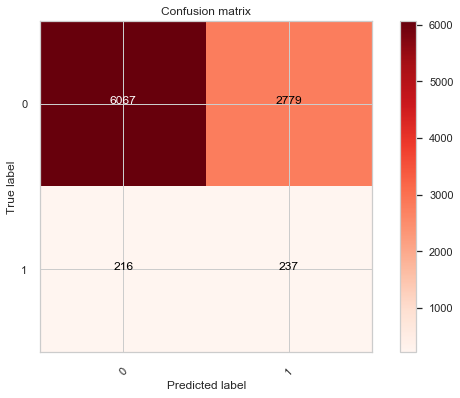

In [36]:
cm = confusion_matrix(y_test,log_kpreds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

Using a K-Best Selector to pick our best columns we found that this is model had a better F1 score than our baseline model but a .14 F1 score isn't all that great.

## GridSearch Log Reg

In [590]:
logreg = LogisticRegression()
parameters = {'C': [0.75,1.0,1.25,1.5],
             'max_iter': [100,200,300,400,500],
             'penalty': ['l1', 'l2']}
grid_tree1=GridSearchCV(logreg, parameters, cv=5, scoring='f1',verbose =1,n_jobs=-1)

grid_tree1.fit(X_train_resampled,y_train_resampled)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.4s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.75, 1.0, 1.25, 1.5],
                         'max_iter': [100, 200, 300, 400, 500],
                         'penalty': ['l1', 'l2']},
             scoring='f1', verbose=1)

In [591]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree1.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree1.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree1.best_estimator_)

0.31038169272237653
{'C': 0.75, 'max_iter': 100, 'penalty': 'l2'}
LogisticRegression(C=0.75)


In [592]:
#Predict the response for test dataset
y_pred = grid_tree1.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred, target_names=['Top 200','Top 10']))

              precision    recall  f1-score   support

     Top 200       0.96      0.54      0.69      8816
      Top 10       0.05      0.51      0.10       457

    accuracy                           0.54      9273
   macro avg       0.50      0.53      0.39      9273
weighted avg       0.91      0.54      0.66      9273



[[4736 4080]
 [ 222  235]]


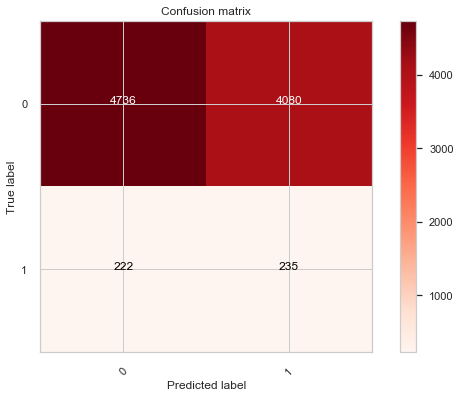

In [593]:
cm = confusion_matrix(y_test,y_pred)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

Our Gridsearch on Logistic Regression performed the same as our best Logistic Regression model with an F1 score of 10%

## KNN Model

In [594]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_resampled, y_train_resampled)

knn_preds = knn.predict(X_test)

knn_f1 = metrics.f1_score(y_test, knn_preds)

knn_acc = metrics.accuracy_score(y_test, knn_preds)

print(classification_report(y_test, knn_preds, target_names=['Top 200','Top 10']))

              precision    recall  f1-score   support

     Top 200       0.99      0.87      0.92      8816
      Top 10       0.23      0.76      0.36       457

    accuracy                           0.87      9273
   macro avg       0.61      0.82      0.64      9273
weighted avg       0.95      0.87      0.90      9273



[[7678 1138]
 [ 110  347]]


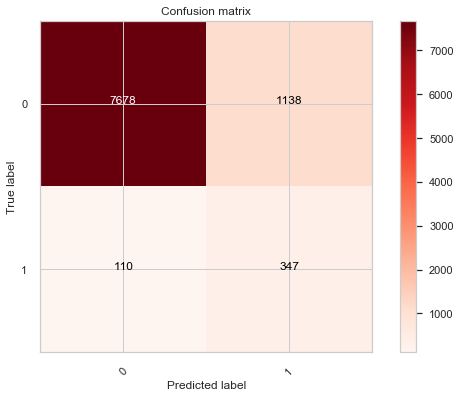

In [595]:
cm = confusion_matrix(y_test,knn_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

Our KNN model performed significantly better than our previous best model with a .36 F1 score.

## Decision Tree Model

In [596]:
dtc = DecisionTreeClassifier(random_state = 25)

dtc.fit(X_train_resampled, y_train_resampled)

dtc_preds  = dtc.predict(X_test)

dtc_f1 = metrics.f1_score(y_test, dtc_preds)

dtc_acc = metrics.accuracy_score(y_test, dtc_preds)

print(classification_report(y_test, dtc_preds, target_names=['Top 200','Top 10']))

              precision    recall  f1-score   support

     Top 200       0.99      0.86      0.92      8816
      Top 10       0.23      0.83      0.37       457

    accuracy                           0.86      9273
   macro avg       0.61      0.84      0.64      9273
weighted avg       0.95      0.86      0.89      9273



[[7576 1240]
 [  78  379]]


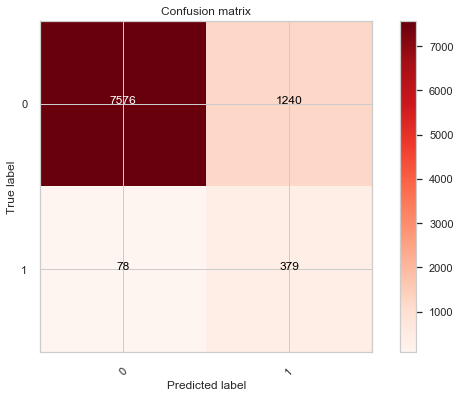

In [597]:
cm = confusion_matrix(y_test,dtc_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

Our Decision Tree outperformed the KNN model with an F1 score of 37%

### Decision Tree Class Weight Balanced

In [598]:
clf = DecisionTreeClassifier(class_weight='balanced')
scores = {}


In [599]:
clf = clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train))
df_master = metrics.f1_score(y_test, y_pred_test)
print("Testing F1 Score:",df_features)

Training F1 Score: 0.36810240442829956
Testing F1 Score:        danceability  energy  loudness  speechiness  acousticness  \
0             0.825   0.652    -3.183        0.080         0.581   
1             0.624   0.876    -3.374        0.100         0.074   
2             0.640   0.533    -6.596        0.071         0.119   
3             0.461   0.834    -4.868        0.099         0.023   
4             0.617   0.635    -6.769        0.032         0.050   
...             ...     ...       ...          ...           ...   
30990         0.791   0.746    -4.716        0.091         0.009   
30991         0.729   0.545    -7.818        0.032         0.017   
30992         0.671   0.373   -18.064        0.032         0.257   
30993         0.626   0.880    -2.384        0.050         0.205   
30994         0.621   0.743    -3.864        0.074         0.281   

       instrumentalness  liveness  valence    tempo  duration  
0                   0.0     0.093    0.931   95.977    233713 

In [600]:
metrics.accuracy_score(y_test, y_pred_test)

0.8282109349725008

In [614]:
importance = clf.feature_importances_
dt_coef = list(zip(df_features.columns, importance))

In [615]:
dt_coef = sorted(dt_coef, key=lambda x: abs(x[1]), reverse = True)
dt_coef[0:15]

[('duration', 0.1571872728917043),
 ('liveness', 0.15085107527868655),
 ('tempo', 0.1380435496673679),
 ('valence', 0.13801515656471408),
 ('speechiness', 0.09941770205844766),
 ('loudness', 0.0897197298123442),
 ('acousticness', 0.0837082273815315),
 ('energy', 0.06184575594328518),
 ('danceability', 0.05652567865923156),
 ('instrumentalness', 0.024685851742687004)]

In [603]:
scores['Decision Tree'] = [metrics.f1_score(y_train, y_pred_train), metrics.f1_score(y_test, y_pred_test), metrics.accuracy_score(y_test, y_pred_test)]


In [604]:
scores


{'Decision Tree': [0.36810240442829956,
  0.3381803074366431,
  0.8282109349725008]}

By looking at the class weight balanced Deciison Tree, we see that the most noteworth features when determinging a Top 10 song are: Duration, Liveness, Tempo and Valence.

## Random Forest Models

In [605]:
rfc = RandomForestClassifier(random_state = 25, n_estimators=20, max_features=6)
rfc.fit(X_train_resampled, y_train_resampled)
rfc_preds = rfc.predict(X_test)

rfc_f1 = metrics.f1_score(y_test, rfc_preds)
rfc_acc = metrics.accuracy_score(y_test, rfc_preds)

# checking accuracy on the test data
print(classification_report(y_test, rfc_preds, target_names=['Top 200','Top 10']))

              precision    recall  f1-score   support

     Top 200       0.99      0.86      0.92      8816
      Top 10       0.24      0.84      0.37       457

    accuracy                           0.86      9273
   macro avg       0.62      0.85      0.65      9273
weighted avg       0.95      0.86      0.90      9273



[[7607 1209]
 [  74  383]]


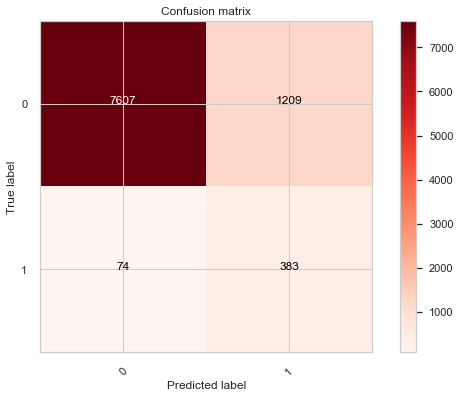

In [606]:
cm = confusion_matrix(y_test,rfc_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

The Random Forest model performed similar to our decision treehad the same results as our decision tree with an f1 score of .37

In [607]:
param_grid2 = { 
    'n_estimators': [50,100,150,200],
    'max_features': [4,5,6,7,8],
    'criterion' : ['gini','entropy']
    
}

rfc_CV = RandomForestClassifier(random_state = 25)
rfc_CV = GridSearchCV(estimator=rfc_CV, param_grid=param_grid2, cv= 10, scoring='f1', verbose=1, n_jobs=-1)
rfc_CV.fit(X_train_resampled, y_train_resampled)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 36.1min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=25),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [4, 5, 6, 7, 8],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1', verbose=1)

In [608]:
# Identify the best params 
print(rfc_CV.best_params_)
print(rfc_CV.best_estimator_)


#Identify the best score during fitting with cross-validation
print(rfc_CV.best_score_)

#predict on the test set
test_preds_rfc_CV = rfc_CV.best_estimator_.predict(X_test)

# checking metrics
print(classification_report(y_test, test_preds_rfc_CV, target_names=['Top 200','Top 10']))

{'criterion': 'entropy', 'max_features': 4, 'n_estimators': 100}
RandomForestClassifier(criterion='entropy', max_features=4, random_state=25)
0.9213611408761878
              precision    recall  f1-score   support

     Top 200       0.99      0.86      0.92      8816
      Top 10       0.24      0.83      0.37       457

    accuracy                           0.86      9273
   macro avg       0.62      0.85      0.65      9273
weighted avg       0.95      0.86      0.90      9273



[[7625 1191]
 [  78  379]]


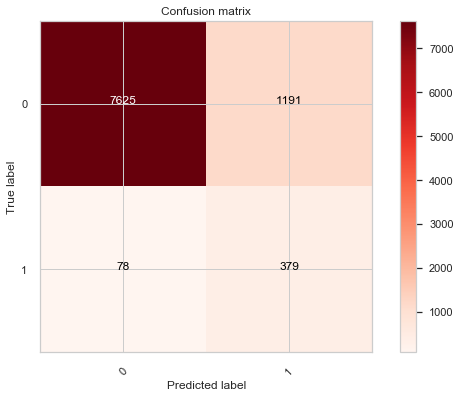

In [609]:
cm = confusion_matrix(y_test,test_preds_rfc_CV)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

In [611]:
rf_coef = list(zip(df_features.columns, rfc.feature_importances_))
rf_coef = sorted(rf_coef, key=lambda x: abs(x[1]), reverse = True)

In [612]:
rf_coef[0:15]


[('liveness', 0.13856450371489015),
 ('duration', 0.13418215703082687),
 ('energy', 0.13145760225385641),
 ('tempo', 0.12911558396700318),
 ('valence', 0.09689952202795116),
 ('danceability', 0.09405264660622166),
 ('acousticness', 0.09308142984125414),
 ('speechiness', 0.08831439625289686),
 ('loudness', 0.07881406553635549),
 ('instrumentalness', 0.015518092768744102)]

The most important features when determining a Top 10 song after utilizing the class weight balance on our Rnadom Forest model were: Livenss, Duration, Energy, and Tempo. Unlike our Decision Tree model, Valence was not included in this list.

Our Gridsearch didn't help with finding a better model

## Voting Classifier

Utilizing the different models, can a voting classifier put the models together and get better results?

In [58]:
voting_clf = VotingClassifier(
                estimators=[('knneighbors', knn), ('decisiontree', dtc), ('logreg', log), ('randomforest', rfc)], 
                voting='hard', weights= [2,2,1,1])

voting_clf.fit(X_train_resampled, y_train_resampled)

vc_preds = voting_clf.predict(X_test)

vc_f1 = metrics.f1_score(y_test, vc_preds)

vc_acc = metrics.accuracy_score(y_test, vc_preds)

print(classification_report(y_test, vc_preds, target_names=['Top 200','Top 10']))

              precision    recall  f1-score   support

     Top 200       0.98      0.89      0.94      8846
      Top 10       0.25      0.72      0.38       453

    accuracy                           0.88      9299
   macro avg       0.62      0.81      0.66      9299
weighted avg       0.95      0.88      0.91      9299



[[7872  974]
 [ 126  327]]


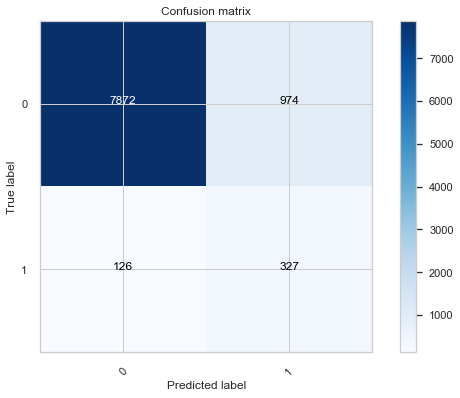

In [44]:
cm = confusion_matrix(y_test,vc_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)

The voting classifier is our best model with a .38 F1 score.

## XG-Boost

In [81]:
labels = df_modeling['Top_10']
labels_removed_df = df_modeling.drop(columns='Top_10')

scaler = StandardScaler()
scaled_df = scaler.fit_transform(labels_removed_df)

X_train, X_test, y_train, y_test = train_test_split(scaled_df, labels)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
X_train, y_train= X_train_resampled, y_train_resampled
 #Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

-----------------------------------------
Synthetic sample class distribution: 

1    22075
0    22075
Name: Top_10, dtype: int64


In [82]:
param_grid = {
    "penalty": (["l1",'l2']),
    "max_depth":([2,3,4]),
    "C": ([0.001,.0001]),
    'learning_rate': [.1,.2,.3],
    "solver": (["newton-cg"]),
}

In [83]:
clf = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='f1', cv=10, n_jobs=-1,verbose=1)
grid_clf.fit(scaled_df, labels)
best_parameters = grid_clf.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
print(classification_report(y_test, val_preds, target_names=['Top 200','Top 10']))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 72.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 137.9min finished


[23:36:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { C, penalty, solver } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Grid Search found the following optimal parameters: 
C: 0.001
learning_rate: 0.3
max_depth: 4
penalty: 'l1'
solver: 'newton-cg'
              precision    recall  f1-score   support

     Top 200       0.96      1.00      0.98      7372
      Top 10       0.76      0.15      0.25       377

    accuracy                           0.96      7749
   macro avg       0.86      0.57      0.61      7749
weighted avg       0.95      0.96      0.94      7749



[[7923  923]
 [ 136  317]]


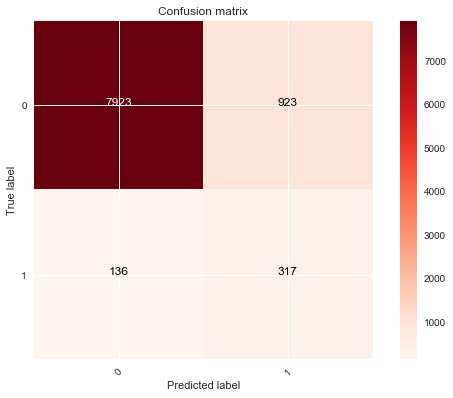

In [85]:
### cm = confusion_matrix(y_test,val_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

Unfortunately our XG-Boost performed worse than our Voting Classifier. Going through all the models our Voting Classifier finished as our best model.